In this code, we demonstrate a voting approach for anomaly detection using the Vector Autoregression (VAR), Isolation Forest (IF), and Long Short-Term Memory (LSTM) autoencoder models applied separately on multivariate time series data.
this approach started my Lab2

In [12]:
%matplotlib inline
from sklearn.decomposition import PCA
# Filter warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import seaborn as sn

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection
from sklearn.feature_selection import VarianceThreshold
import math


# Data preprocessing

Loading the data

In [13]:
df = pd.read_csv('mit.csv')
print("Data size:", df.shape) # print data size

Data size: (96893, 24)


In [14]:
df.drop('Unnamed: 0', axis=1, inplace=True) 
df.drop('Time.1', axis=1, inplace=True) 
df.set_index('Time')
df.head()

,Time,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,...,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job
0,2020-12-01 01:00:00,0.0,1.0,157521.0,2.645557e+09,3.0,24.0,0.0,1646.0,1748.0,...,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47,4393785332
1,2020-12-01 01:00:10,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54,18177101425
2,2020-12-01 01:00:20,0.0,3.0,94816.0,2.917171e+07,0.0,0.0,0.0,1846.0,1849.0,...,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30,39529488078
3,2020-12-01 01:00:30,0.0,0.0,69451.0,1.527587e+09,0.0,1.0,0.0,539.0,542.0,...,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72,19994333952
4,2020-12-01 01:00:40,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1991.0,1991.0,...,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99,397881706


Check duplicates

In [15]:
df.duplicated().sum() 

0

Check missing values

In [16]:
df.isnull().sum()/len(df)*100

Time                             0.0
avgmemoryutilization_pct         0.0
avgsmutilization_pct             0.0
energyconsumed_joules            0.0
maxgpumemoryused_bytes           0.0
memoryutilization_pct_avg        0.0
memoryutilization_pct_max        0.0
memoryutilization_pct_min        0.0
pcierxbandwidth_megabytes_avg    0.0
pcierxbandwidth_megabytes_max    0.0
pcierxbandwidth_megabytes_min    0.0
pcietxbandwidth_megabytes_avg    0.0
pcietxbandwidth_megabytes_max    0.0
pcietxbandwidth_megabytes_min    0.0
powerusage_watts_avg             0.0
powerusage_watts_max             0.0
powerusage_watts_min             0.0
smutilization_pct_avg            0.0
smutilization_pct_max            0.0
smutilization_pct_min            0.0
totalexecutiontime_sec           0.0
id_job                           0.0
dtype: float64

Remove columns with only one value

In [17]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)

Make dataset copies to use it in our models

In [19]:
df_backup=df.copy()

In [20]:
df_lstm_bc=df.copy()

In [21]:
df_lstm=df.copy()

In [22]:
len(df)

96893

## Convert to timeseries

In [23]:
timeseries=pd.to_datetime(pd.Series(df['Time']))

In [24]:
df['Time']=timeseries
df=df.set_index('Time')

In [25]:
df.drop('id_job', axis=1, inplace=True) 

In [27]:
for c in df.columns:
    df[c]=pd.to_numeric(df[c])

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96893 entries, 2020-12-01 01:00:00 to 2020-12-12 06:08:40
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   avgmemoryutilization_pct       96893 non-null  float64
 1   avgsmutilization_pct           96893 non-null  float64
 2   energyconsumed_joules          96893 non-null  float64
 3   maxgpumemoryused_bytes         96893 non-null  float64
 4   memoryutilization_pct_avg      96893 non-null  float64
 5   memoryutilization_pct_max      96893 non-null  float64
 6   memoryutilization_pct_min      96893 non-null  float64
 7   pcierxbandwidth_megabytes_avg  96893 non-null  float64
 8   pcierxbandwidth_megabytes_max  96893 non-null  float64
 9   pcierxbandwidth_megabytes_min  96893 non-null  float64
 10  pcietxbandwidth_megabytes_avg  96893 non-null  float64
 11  pcietxbandwidth_megabytes_max  96893 non-null  float64
 12  pcietxbandw

In [29]:
df.shape

(96893, 20)

In [30]:
df.head()

,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
Time,,,,,,,,,,,,,,,,,,,,
2020-12-01 01:00:00,0.0,1.0,157521.0,2.645557e+09,3.0,24.0,0.0,1646.0,1748.0,1613.0,971.0,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47
2020-12-01 01:00:10,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54
2020-12-01 01:00:20,0.0,3.0,94816.0,2.917171e+07,0.0,0.0,0.0,1846.0,1849.0,1838.0,1785.0,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30
2020-12-01 01:00:30,0.0,0.0,69451.0,1.527587e+09,0.0,1.0,0.0,539.0,542.0,536.0,314.0,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72
2020-12-01 01:00:40,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,1991.0,1991.0,1991.0,1109.0,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99


# Descriptive Statistics

In [31]:
df.describe()

,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
count,96893.000000,96893.000000,96893.000000,9.689300e+04,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,96893.000000,9.689300e+04
mean,7.420206,21.231998,98732.099491,7.169812e+09,8.819409,21.771820,0.098397,922.292240,1102.159712,744.184967,874.355733,957.035235,792.028155,66.949795,115.754833,31.547750,24.862436,50.476711,0.400968,2.206985e+04
std,12.625314,28.437426,168706.020958,1.048171e+10,13.520285,25.421592,2.529322,609.972447,738.590877,664.887109,650.611060,714.644379,669.515853,50.563993,92.750007,9.853968,29.566378,43.824541,5.895888,9.998470e+04
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e-02
25%,0.000000,0.000000,1828.000000,0.000000e+00,0.000000,0.000000,0.000000,369.000000,393.000000,119.000000,248.000000,266.000000,102.000000,27.051000,27.503000,25.574000,0.000000,0.000000,0.000000,1.562000e+01
50%,0.000000,3.000000,10234.000000,2.106589e+09,1.000000,10.000000,0.000000,948.000000,1092.000000,561.000000,837.000000,884.000000,708.000000,42.285500,66.502000,27.065000,12.000000,51.000000,0.000000,2.010400e+02
75%,15.000000,46.000000,133714.000000,7.762608e+09,17.000000,43.000000,0.000000,1393.000000,1809.000000,1308.000000,1410.000000,1583.000000,1357.000000,109.944000,222.825000,37.495000,48.000000,100.000000,0.000000,5.596680e+03
max,85.000000,99.000000,868934.000000,3.408396e+10,89.000000,100.000000,86.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,2147.000000,242.436000,337.630000,146.989000,100.000000,100.000000,100.000000,2.895390e+06


# Numerical and Categorical columns :

Below we can see that all our features are numerical

In [32]:
df.nunique()

avgmemoryutilization_pct            85
avgsmutilization_pct               100
energyconsumed_joules            51449
maxgpumemoryused_bytes            8390
memoryutilization_pct_avg           88
memoryutilization_pct_max          101
memoryutilization_pct_min           61
pcierxbandwidth_megabytes_avg     2148
pcierxbandwidth_megabytes_max     2148
pcierxbandwidth_megabytes_min     2148
pcietxbandwidth_megabytes_avg     2148
pcietxbandwidth_megabytes_max     2148
pcietxbandwidth_megabytes_min     2148
powerusage_watts_avg             79657
powerusage_watts_max             58583
powerusage_watts_min             24269
smutilization_pct_avg              101
smutilization_pct_max              101
smutilization_pct_min               84
totalexecutiontime_sec           44872
dtype: int64

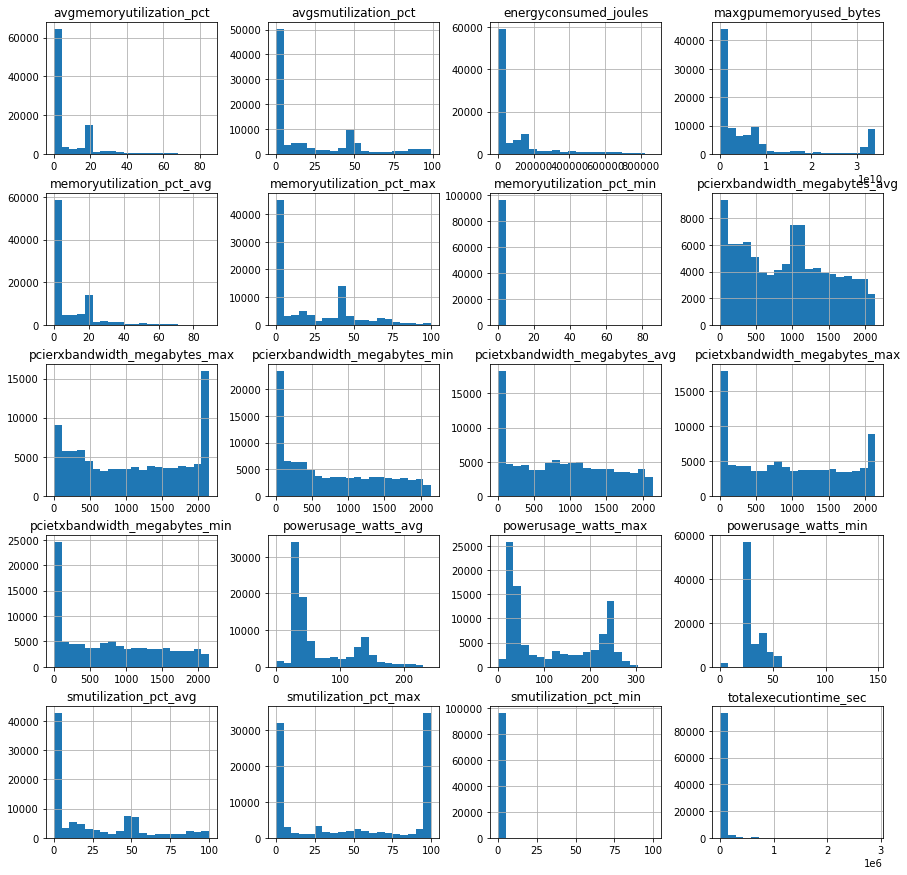

In [41]:
num_features = df.columns
df[num_features].hist(bins=20,figsize=(15, 15))
plt.show()

# Data normalization

In [33]:
df_var = df.copy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df_var)
df_var = pd.DataFrame(x_scaled, index=df_var.index, columns=df_var.columns)

In [34]:
df_var.head()

,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
Time,,,,,,,,,,,,,,,,,,,,
2020-12-01 01:00:00,0.0,0.010101,0.181281,0.077619,0.033708,0.24,0.0,0.766651,0.814159,0.751281,0.452259,0.712622,0.314858,0.181716,0.464894,0.173265,0.11,0.64,0.0,1.537751e-03
2020-12-01 01:00:10,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,1.588732e-07
2020-12-01 01:00:20,0.0,0.030303,0.109118,0.000856,0.000000,0.00,0.0,0.859804,0.861202,0.856078,0.831393,0.871914,0.626921,0.108781,0.081400,0.176741,0.06,0.43,0.0,2.900549e-03
2020-12-01 01:00:30,0.0,0.000000,0.079927,0.044818,0.000000,0.01,0.0,0.251048,0.252445,0.249651,0.146251,0.156963,0.136469,0.154878,0.154130,0.181483,0.01,0.25,0.0,6.395132e-04
2020-12-01 01:00:40,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.927340,0.927340,0.927340,0.516535,0.516535,0.516535,0.103252,0.074140,0.170298,0.00,0.00,0.0,3.142927e-07


# Correlation among features

Since we have only 22 features and all of them have a good correlation with each other. We decide to keep all feautres and use them in our models

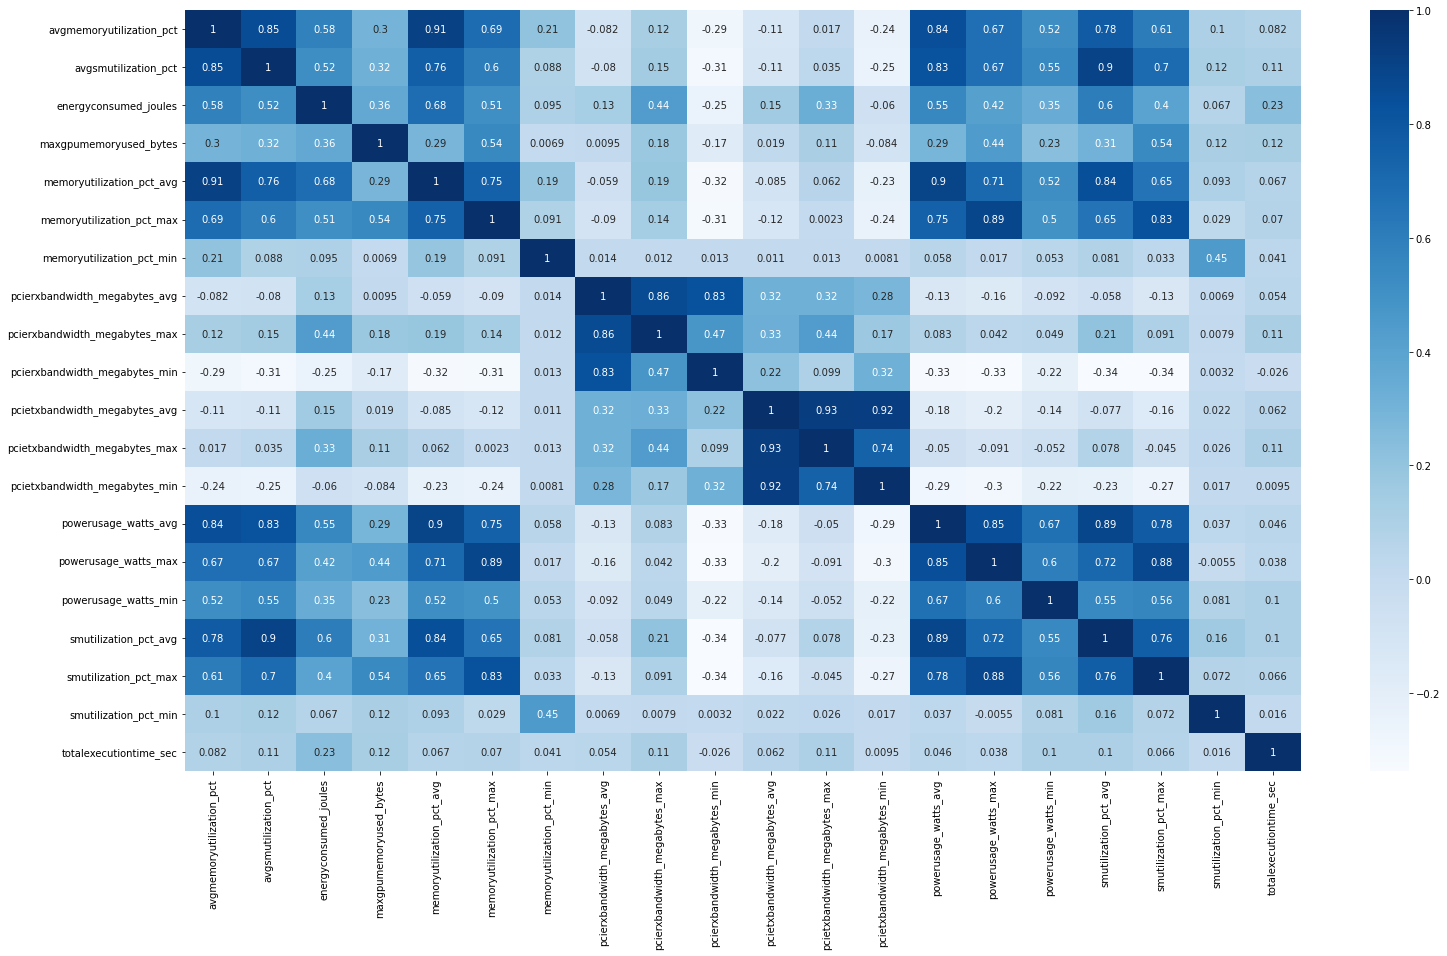

In [35]:
cr=df_var.corr()
plt.figure(figsize = (25,14))
sn.heatmap(cr, annot=True,cmap="Blues")
plt.show()

# Time series visualizations

In [36]:
df_backup.drop('id_job', axis=1, inplace=True) 

In [37]:
timeseries=pd.to_datetime(pd.Series(df_backup['Time']))
df_backup['Time']=timeseries

**Energyconsumed in joules over time**

<AxesSubplot:xlabel='Time'>

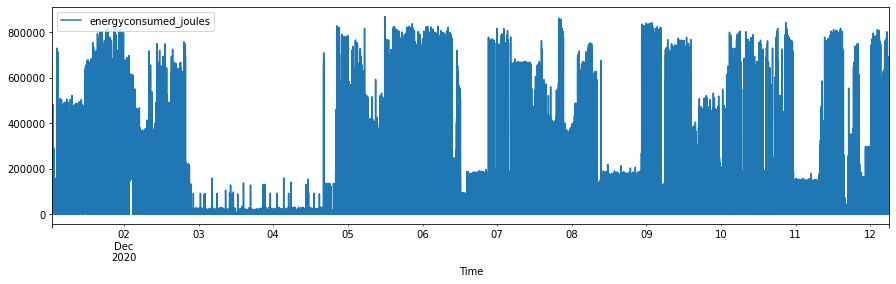

In [38]:
 df_backup.plot(x='Time', y='energyconsumed_joules', figsize=(15,4))

**Average powerusage over time**

<AxesSubplot:xlabel='Time'>

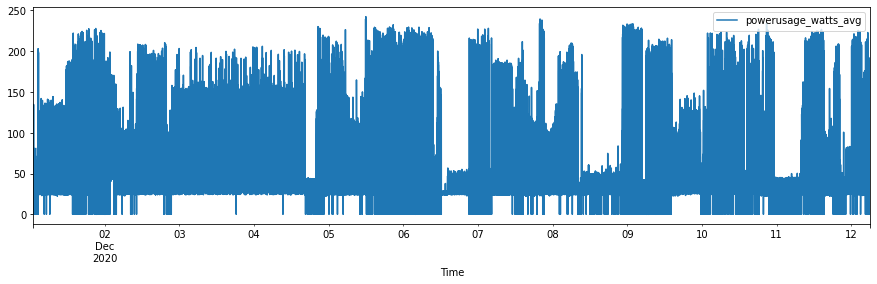

In [39]:
df_backup.plot(x='Time', y='powerusage_watts_avg', figsize=(15,4))

**Average smutilization over time**

<AxesSubplot:xlabel='Time'>

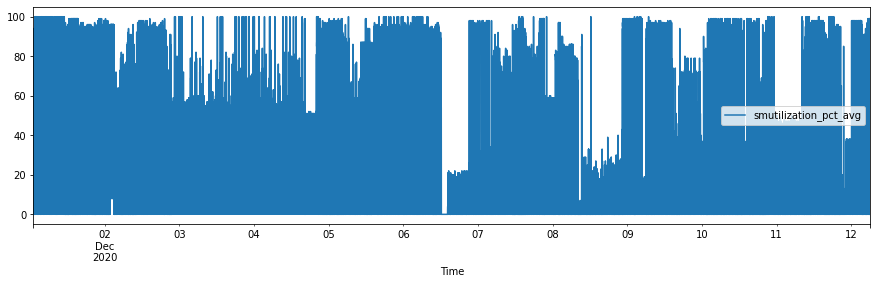

In [40]:
df_backup.plot(x='Time', y='smutilization_pct_avg', figsize=(15,4))

**Hourly data**

In [184]:
df_hourly=df_backup.resample('H', on='Time').mean()

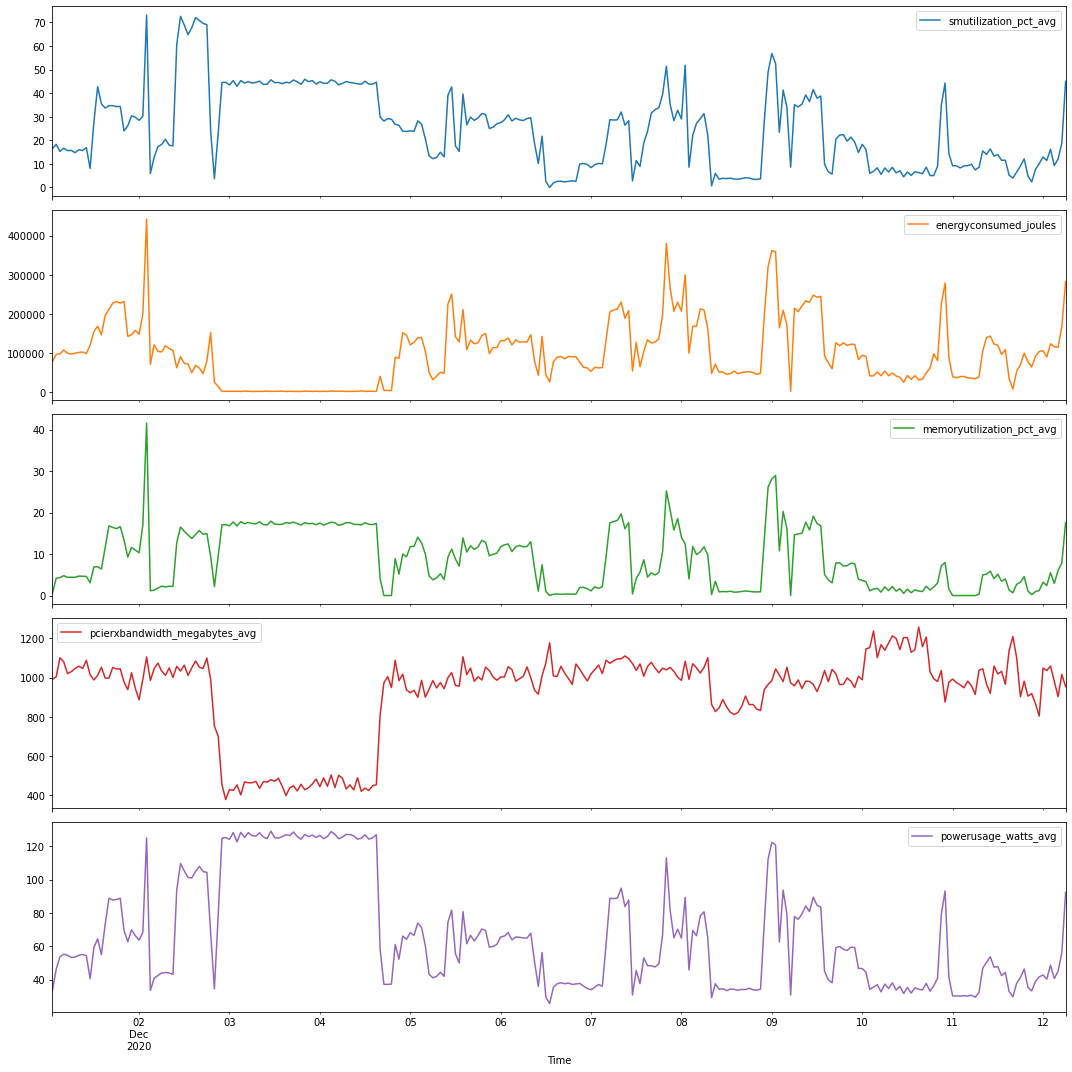

In [185]:
df_hourly[['smutilization_pct_avg','energyconsumed_joules','memoryutilization_pct_avg','pcierxbandwidth_megabytes_avg','powerusage_watts_avg']].plot(subplots=True,figsize=(15,15))
plt.tight_layout()
plt.show()

**Daily data**

In [187]:
df_day=df_backup.resample('24H', on='Time').mean()

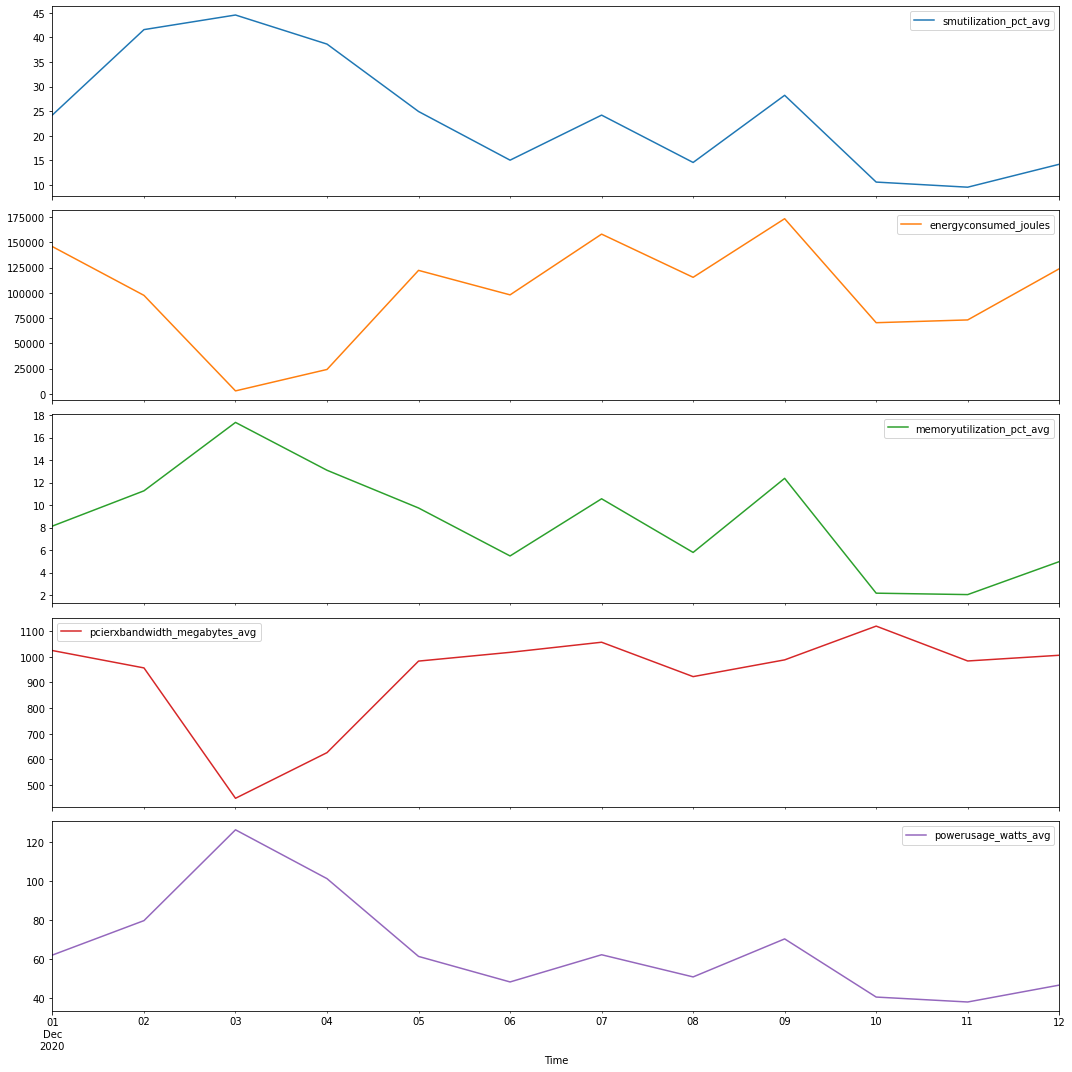

In [188]:
df_day[['smutilization_pct_avg','energyconsumed_joules','memoryutilization_pct_avg','pcierxbandwidth_megabytes_avg','powerusage_watts_avg']].plot(subplots=True,figsize=(15,15))
plt.tight_layout()
plt.show()

# PCA (Principal component Analysis) for VAR model

In [27]:
# Create a PCA object with n_components=10
pca = PCA(n_components=10)

# Fit the PCA model to the data and transform the data
# using the fitted model
reduced_data = pca.fit_transform(df_var)


In [28]:
data=pd.DataFrame(reduced_data)


In [30]:
timeseries

0       2020-12-01 01:00:00
1       2020-12-01 01:00:10
2       2020-12-01 01:00:20
3       2020-12-01 01:00:30
4       2020-12-01 01:00:40
                ...        
96888   2020-12-12 06:08:00
96889   2020-12-12 06:08:10
96890   2020-12-12 06:08:20
96891   2020-12-12 06:08:30
96892   2020-12-12 06:08:40
Name: Time, Length: 96893, dtype: datetime64[ns]

In [31]:
data['Time']=timeseries

In [32]:
data=data.set_index('Time')

In [33]:
data.head()

,0,1,2,3,4,5,6,7,8,9
Time,,,,,,,,,,
2020-12-01 01:00:00,-0.177888,0.443339,-0.375853,0.107686,-0.153396,-0.299995,0.015650,-0.129650,0.239154,0.035204
2020-12-01 01:00:10,-0.541547,-1.160980,0.130517,-0.075644,0.287889,0.023964,0.000858,0.013057,-0.020578,0.116970
2020-12-01 01:00:20,-0.692529,0.798310,-0.180697,-0.020533,-0.172902,-0.088837,0.155085,-0.044562,0.193555,0.116633
2020-12-01 01:00:30,-0.396226,-0.662369,-0.047416,-0.006930,0.103630,-0.047896,0.012338,0.049434,0.072273,0.031460
2020-12-01 01:00:40,-0.917577,0.460260,-0.560377,-0.073519,-0.066771,0.029992,-0.047167,-0.042019,-0.025138,-0.013950


# VAR model

In [34]:
from statsmodels.tsa.stattools import adfuller 

In [35]:
def test_stationarity(data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(data, autolag='AIC')
    else:
        adf_test = adfuller(data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

In [36]:
adf_test_results = {
    col: test_stationarity(data, col)
    for col in data.columns
}
adf_test_results

{0: 'Stationary',
 1: 'Stationary',
 2: 'Stationary',
 3: 'Stationary',
 4: 'Stationary',
 5: 'Stationary',
 6: 'Stationary',
 7: 'Stationary',
 8: 'Stationary',
 9: 'Stationary'}

In [37]:
data.head()

,0,1,2,3,4,5,6,7,8,9
Time,,,,,,,,,,
2020-12-01 01:00:00,-0.177888,0.443339,-0.375853,0.107686,-0.153396,-0.299995,0.015650,-0.129650,0.239154,0.035204
2020-12-01 01:00:10,-0.541547,-1.160980,0.130517,-0.075644,0.287889,0.023964,0.000858,0.013057,-0.020578,0.116970
2020-12-01 01:00:20,-0.692529,0.798310,-0.180697,-0.020533,-0.172902,-0.088837,0.155085,-0.044562,0.193555,0.116633
2020-12-01 01:00:30,-0.396226,-0.662369,-0.047416,-0.006930,0.103630,-0.047896,0.012338,0.049434,0.072273,0.031460
2020-12-01 01:00:40,-0.917577,0.460260,-0.560377,-0.073519,-0.066771,0.029992,-0.047167,-0.042019,-0.025138,-0.013950


In [39]:
from statsmodels.tsa.api import VAR
max_lag = 10
var_model = VAR(data)
# select the best lag order
lag_results = var_model.select_order()
print(lag_results.aic)

C:\Users\Zakaria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  warnings.warn('No frequency information was'


62


In [40]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) +np.std(squared_errors)
    print(threshold)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(data)
var_fitresults = var.fit(lag_results.aic)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)

C:\Users\Zakaria\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  warnings.warn('No frequency information was'


2.7125423177754273


In [41]:
predictions.value_counts()

0    86163
1    10668
dtype: int64

In [42]:
res = data.iloc[62:, :]
res['Predictions'] = predictions.values
res['Predictions'].value_counts()

0    86163
1    10668
Name: Predictions, dtype: int64

# PCA for LSTM


improve the performance of the autoencoder, to extract more meaningful features

In [71]:
data_lstm=df_var.copy() #df_var is the normalized DF

In [72]:
data_lstm.head()

,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec
Time,,,,,,,,,,,,,,,,,,,,
2020-12-01 01:00:00,0.0,0.010101,0.181281,0.077619,0.033708,0.24,0.0,0.766651,0.814159,0.751281,0.452259,0.712622,0.314858,0.181716,0.464894,0.173265,0.11,0.64,0.0,1.537751e-03
2020-12-01 01:00:10,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.0,1.588732e-07
2020-12-01 01:00:20,0.0,0.030303,0.109118,0.000856,0.000000,0.00,0.0,0.859804,0.861202,0.856078,0.831393,0.871914,0.626921,0.108781,0.081400,0.176741,0.06,0.43,0.0,2.900549e-03
2020-12-01 01:00:30,0.0,0.000000,0.079927,0.044818,0.000000,0.01,0.0,0.251048,0.252445,0.249651,0.146251,0.156963,0.136469,0.154878,0.154130,0.181483,0.01,0.25,0.0,6.395132e-04
2020-12-01 01:00:40,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.927340,0.927340,0.927340,0.516535,0.516535,0.516535,0.103252,0.074140,0.170298,0.00,0.00,0.0,3.142927e-07


In [76]:
# Create a PCA object with n_components=15
pca = PCA(n_components=15)

# Fit the PCA model to the data and transform the data
# using the fitted model
reduced_data = pca.fit_transform(data_lstm)

In [77]:
data_lstm=pd.DataFrame(reduced_data)
data_lstm['Time']=timeseries
data_lstm=data_lstm.set_index('Time')

# Long Short-Term Memory (LSTM) Autoencoder

In [78]:
DF_LSTM = data_lstm
DF_LSTM = DF_LSTM.sort_index()

In [79]:
DF_LSTM.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Time,,,,,,,,,,,,,,,
2020-12-01 01:00:00,-0.177888,0.443339,-0.375853,0.107686,-0.153396,-0.299995,0.015650,-0.129650,0.239154,0.035204,-0.063168,0.023320,0.015330,0.074630,0.017673
2020-12-01 01:00:10,-0.541547,-1.160980,0.130517,-0.075644,0.287889,0.023964,0.000858,0.013057,-0.020578,0.116970,0.072929,0.075067,-0.064554,0.127692,-0.004104
2020-12-01 01:00:20,-0.692529,0.798310,-0.180697,-0.020533,-0.172902,-0.088837,0.155085,-0.044562,0.193555,0.116633,-0.005489,-0.075747,-0.010367,0.011401,0.002104
2020-12-01 01:00:30,-0.396226,-0.662369,-0.047416,-0.006930,0.103630,-0.047896,0.012338,0.049434,0.072273,0.031460,-0.041544,-0.034729,0.003715,0.014423,-0.000899
2020-12-01 01:00:40,-0.917577,0.460260,-0.560377,-0.073519,-0.066771,0.029992,-0.047167,-0.042019,-0.025138,-0.013950,0.020496,-0.007103,0.000197,0.001180,0.003281


In [80]:
len(DF_LSTM)

96893

In [82]:
train = DF_LSTM[:63000]
test = DF_LSTM[63000:]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (63000, 15)
Test dataset shape: (33893, 15)


In [83]:
# normalize the data
from sklearn.preprocessing import MinMaxScaler
import joblib
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [84]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (63000, 1, 15)
Test data shape: (33893, 1, 15)


In [85]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [86]:
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras import regularizers
from keras.models import Model

# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 15)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             2048      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

In [87]:
# fit the model to the data
nb_epochs = 30
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size).history

Epoch 1/30
6300/6300 [==============================] - 55s 7ms/step - loss: 0.0668
Epoch 2/30
6300/6300 [==============================] - 47s 7ms/step - loss: 0.0504
Epoch 3/30
6300/6300 [==============================] - 42s 7ms/step - loss: 0.0417
Epoch 4/30
6300/6300 [==============================] - 36s 6ms/step - loss: 0.0400
Epoch 5/30
6300/6300 [==============================] - 32s 5ms/step - loss: 0.0392
Epoch 6/30
6300/6300 [==============================] - 31s 5ms/step - loss: 0.0387
Epoch 7/30
6300/6300 [==============================] - 32s 5ms/step - loss: 0.0375
Epoch 8/30
6300/6300 [==============================] - 34s 5ms/step - loss: 0.0358
Epoch 9/30
6300/6300 [==============================] - 36s 6ms/step - loss: 0.0350
Epoch 10/30
6300/6300 [==============================] - 38s 6ms/step - loss: 0.0346
Epoch 11/30
6300/6300 [==============================] - 31s 5ms/step - loss: 0.0342
Epoch 12/30
6300/6300 [==============================] - 27s 4ms/step - lo

1969/1969 [==============================] - 6s 3ms/step


(0.0, 0.5)

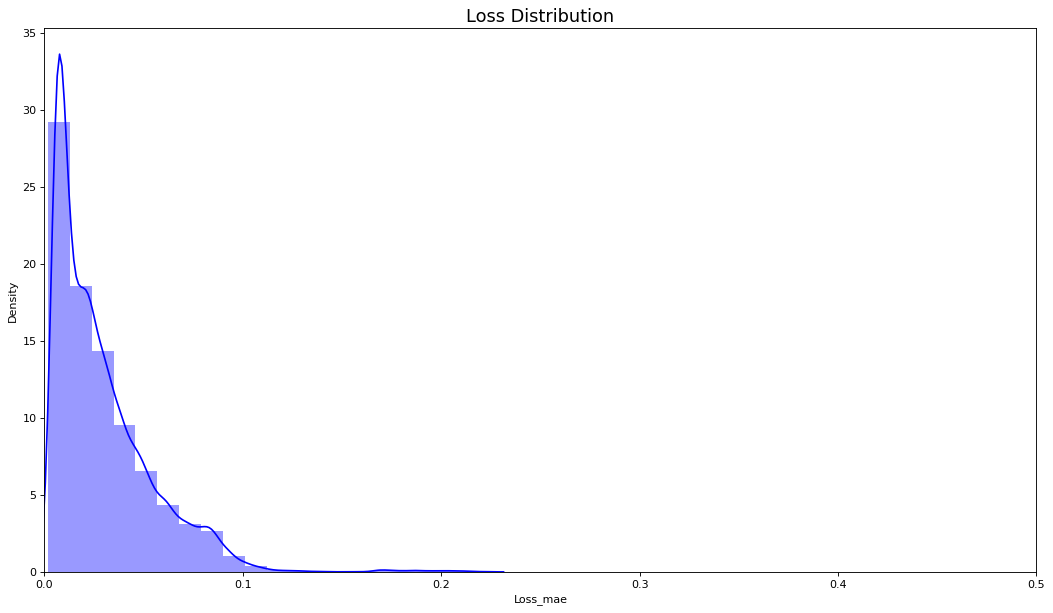

In [89]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [96]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored_test['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored_test['Threshold'] = 0.07
scored_test['Predictions'] = scored_test['Loss_mae'] > scored_test['Threshold']
scored_test['Predictions'] = scored_test['Predictions'].replace({False: 'Normal', True: 'anomaly'})
scored_test.head()

1060/1060 [==============================] - 3s 3ms/step


,Loss_mae,Threshold,Predictions
Time,,,
2020-12-08 08:00:00,0.005812,0.07,Normal
2020-12-08 08:00:10,0.009925,0.07,Normal
2020-12-08 08:00:20,0.067710,0.07,Normal
2020-12-08 08:00:30,0.008092,0.07,Normal
2020-12-08 08:00:40,0.008370,0.07,Normal


In [97]:
# calculate the same metrics for the training set 
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.07
scored_train['Predictions'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_train['Predictions'] = scored_train['Predictions'].replace({False: 'Normal', True: 'anomaly'})

1969/1969 [==============================] - 6s 3ms/step


In [98]:
scored = pd.concat([scored_train, scored_test])
scored['Predictions'].value_counts()

Normal     89378
anomaly     7515
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Time'>

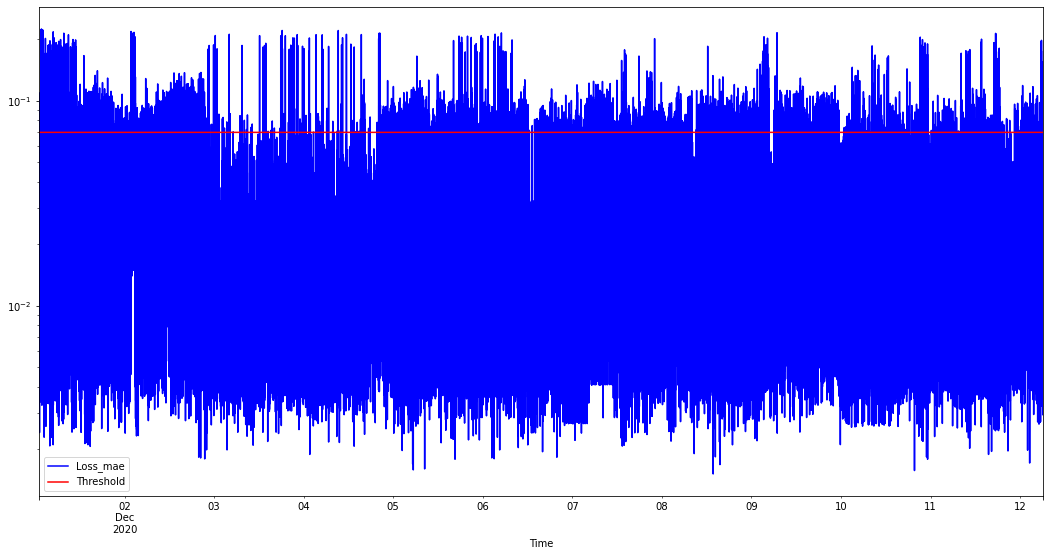

In [103]:
scored.plot(logy=True,  figsize=(18,9), color=['blue','red'])

# Isolation Forest model

In [148]:
df_IF=DF_LSTM.copy()

In [149]:
random_state = np.random.RandomState(42)

#model=IsolationForest(n_estimators=5,max_samples=5,max_features=5,contamination=0.15,bootstrap=True,n_jobs=5,random_state=random_state)
model=IsolationForest(contamination=0.1)

model.fit(df_IF)

print(model.get_params())

{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [150]:
df_IF.columns=df_IF.columns.astype(str)

In [151]:
md = model.decision_function(df_IF)
mp = model.predict(df_IF)

df_IF['scores'] = md
df_IF['Anomaly'] = mp
df_IF['Anomaly'] = df_IF.Anomaly.replace({-1: True, 1: False})

In [157]:
df_IF['Anomaly'] = df_IF.Anomaly.replace({True: 1, False:0})

In [158]:
df_IF.Anomaly.value_counts()

0    87203
1     9690
Name: Anomaly, dtype: int64

# Comparing VAR LSTM IF

In [109]:
res_lstm = scored.iloc[62:, :]
res_lstm=res_lstm['Predictions'].replace({ 'Normal':0,'anomaly':1})

In [123]:
res_lstm.values

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [159]:
res_if=df_IF.iloc[62:, :]

In [115]:
res['lstm_pre']=res_lstm.values

In [160]:
res['if_pre']=res_if['Anomaly'].values

In [161]:
res #Predictions is the results of the VAR

,0,1,2,3,4,5,6,7,8,9,Predictions,lstm_pre,if_pre
Time,,,,,,,,,,,,,
2020-12-01 01:10:20,-0.541547,-1.160980,0.130517,-0.075644,0.287889,0.023964,0.000858,0.013057,-0.020578,0.116970,0,0,0
2020-12-01 01:10:30,-0.688925,-0.310772,0.363096,-0.107576,0.119961,0.009358,-0.089497,0.028917,0.029221,0.019126,0,0,0
2020-12-01 01:10:40,-0.174196,-0.411176,0.492775,0.070938,-0.017034,-0.200024,-0.087851,-0.003288,0.115283,-0.020767,0,0,0
2020-12-01 01:10:50,-0.891737,0.430956,0.520508,-0.099740,-0.039158,0.014892,-0.085602,0.005566,0.020380,0.011671,0,0,0
2020-12-01 01:11:00,-0.677786,0.030947,-0.167151,-0.056425,0.052652,-0.003071,-0.109492,0.027530,0.058779,-0.026608,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-12 06:08:00,-0.532369,-0.958333,0.059365,-0.092699,0.214636,0.014204,-0.046405,-0.000534,-0.010922,0.007546,1,0,0
2020-12-12 06:08:10,-0.900731,0.673924,-0.202088,-0.030166,-0.129257,0.014889,-0.029902,-0.026256,-0.000375,-0.007845,0,0,0
2020-12-12 06:08:20,1.189940,0.930474,-0.584659,-0.062409,0.055985,0.752093,-0.123119,0.261834,0.218538,-0.058491,1,1,1


In [166]:
idx = (res["if_pre"] == 1) & (res["Predictions"] == 1)  & (res["lstm_pre"] == 1) 

# Count the number of rows where both columns are equal to 1 (INTERSECTION)
count = idx.sum()

print(count)

1482


# VAR vs LSTM

In [163]:
idx = (res["Predictions"] == 1) & (res["lstm_pre"] == 1) 

# Count the number of rows where both columns are equal to 1 (INTERSECTION)
count = idx.sum()

print(count)

1845


# LSTM vs IF

In [164]:
idx = (res["if_pre"] == 1) & (res["lstm_pre"] == 1) 

# Count the number of rows where both columns are equal to 1 (INTERSECTION)
count = idx.sum()

print(count)

5856


# VAR vs IF

In [165]:
idx = (res["if_pre"] == 1) & (res["Predictions"] == 1) 

# Count the number of rows where both columns are equal to 1 (INTERSECTION)
count = idx.sum()

print(count)

2770


# Conclusion

Our three models were able to identify the same 1482 points that deviated significantly from the norm. This suggests that these points are likely to be anomalous.